In [3]:
%pip install torch
%pip install torchvision
%pip install numpy
%pip install torchsummary
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [5]:
from torchvision import datasets, transforms

# Train Phase transformations
train_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))
                                      ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [6]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)

test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [7]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? False


In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1) # 28>28 | 3
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1) # 28 > 28 |  5
        self.pool1 = nn.MaxPool2d(2, 2) # 28 > 14 | 10
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1) # 14> 14 | 12
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1) #14 > 14 | 14
        self.pool2 = nn.MaxPool2d(2, 2) # 14 > 7 | 28
        self.conv5 = nn.Conv2d(256, 512, 3) # 7 > 5 | 30
        self.conv6 = nn.Conv2d(512, 1024, 3) # 5 > 3 | 32 | 3*3*1024 | 3x3x1024x10 |
        self.conv7 = nn.Conv2d(1024, 10, 3) # 3 > 1 | 34 | > 1x1x10

    def forward(self, x):
        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
        x = F.relu(self.conv6(F.relu(self.conv5(x))))
        # x = F.relu(self.conv7(x))
        x = self.conv7(x)
        x = x.view(-1, 10) #1x1x10> 10
        return F.log_softmax(x, dim=-1)

In [13]:
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

model = Net().to(device)
summary(model, input_size=(1, 28, 28)) 

device = torch.device("mps") if torch.backends.mps.is_available() else "cpu"
model = Net().to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 64, 28, 28]          18,496
         MaxPool2d-3           [-1, 64, 14, 14]               0
            Conv2d-4          [-1, 128, 14, 14]          73,856
            Conv2d-5          [-1, 256, 14, 14]         295,168
         MaxPool2d-6            [-1, 256, 7, 7]               0
            Conv2d-7            [-1, 512, 5, 5]       1,180,160
            Conv2d-8           [-1, 1024, 3, 3]       4,719,616
            Conv2d-9             [-1, 10, 1, 1]          92,170
Total params: 6,379,786
Trainable params: 6,379,786
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.51
Params size (MB): 24.34
Estimated Total Size (MB): 25.85
-------------------------------------

In [10]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [11]:
model =  Net().to(device)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 20

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.008212554268538952 Batch_id=937 Accuracy=91.24: 100%|██████████| 938/938 [00:34<00:00, 27.52it/s]



Test set: Average loss: 0.0504, Accuracy: 9824/10000 (98.24%)

EPOCH: 1


Loss=0.04143161326646805 Batch_id=937 Accuracy=98.71: 100%|██████████| 938/938 [00:34<00:00, 26.86it/s]  



Test set: Average loss: 0.0270, Accuracy: 9895/10000 (98.95%)

EPOCH: 2


Loss=0.003087820950895548 Batch_id=937 Accuracy=99.14: 100%|██████████| 938/938 [00:32<00:00, 29.25it/s]  



Test set: Average loss: 0.0267, Accuracy: 9917/10000 (99.17%)

EPOCH: 3


Loss=0.030362138524651527 Batch_id=937 Accuracy=99.36: 100%|██████████| 938/938 [00:45<00:00, 20.68it/s]  



Test set: Average loss: 0.0306, Accuracy: 9900/10000 (99.00%)

EPOCH: 4


Loss=0.0013320635771378875 Batch_id=937 Accuracy=99.54: 100%|██████████| 938/938 [00:35<00:00, 26.75it/s] 



Test set: Average loss: 0.0344, Accuracy: 9891/10000 (98.91%)

EPOCH: 5


Loss=0.044212307780981064 Batch_id=937 Accuracy=99.65: 100%|██████████| 938/938 [00:45<00:00, 20.60it/s]  



Test set: Average loss: 0.0290, Accuracy: 9908/10000 (99.08%)

EPOCH: 6


Loss=0.0011715389555320144 Batch_id=937 Accuracy=99.76: 100%|██████████| 938/938 [00:44<00:00, 21.12it/s] 



Test set: Average loss: 0.0240, Accuracy: 9928/10000 (99.28%)

EPOCH: 7


Loss=0.00017238994769286364 Batch_id=937 Accuracy=99.80: 100%|██████████| 938/938 [00:45<00:00, 20.67it/s]



Test set: Average loss: 0.0249, Accuracy: 9922/10000 (99.22%)

EPOCH: 8


Loss=0.15357419848442078 Batch_id=937 Accuracy=99.83: 100%|██████████| 938/938 [00:34<00:00, 27.13it/s]   



Test set: Average loss: 0.0247, Accuracy: 9925/10000 (99.25%)

EPOCH: 9


Loss=0.03852778300642967 Batch_id=937 Accuracy=99.89: 100%|██████████| 938/938 [00:46<00:00, 20.36it/s]   



Test set: Average loss: 0.0253, Accuracy: 9925/10000 (99.25%)

EPOCH: 10


Loss=0.00029027374694123864 Batch_id=937 Accuracy=99.89: 100%|██████████| 938/938 [00:46<00:00, 20.16it/s]



Test set: Average loss: 0.0281, Accuracy: 9931/10000 (99.31%)

EPOCH: 11


Loss=2.9557770176324993e-05 Batch_id=937 Accuracy=99.88: 100%|██████████| 938/938 [00:45<00:00, 20.65it/s]



Test set: Average loss: 0.0397, Accuracy: 9907/10000 (99.07%)

EPOCH: 12


Loss=2.145784310414456e-05 Batch_id=937 Accuracy=99.95: 100%|██████████| 938/938 [00:34<00:00, 27.07it/s] 



Test set: Average loss: 0.0289, Accuracy: 9935/10000 (99.35%)

EPOCH: 13


Loss=1.4655915947514586e-05 Batch_id=937 Accuracy=99.97: 100%|██████████| 938/938 [00:45<00:00, 20.59it/s] 



Test set: Average loss: 0.0338, Accuracy: 9932/10000 (99.32%)

EPOCH: 14


Loss=1.5829451513127424e-05 Batch_id=937 Accuracy=99.96: 100%|██████████| 938/938 [00:46<00:00, 20.08it/s]



Test set: Average loss: 0.0326, Accuracy: 9926/10000 (99.26%)

EPOCH: 15


Loss=1.4302627278084401e-05 Batch_id=937 Accuracy=99.97: 100%|██████████| 938/938 [00:34<00:00, 27.27it/s]



Test set: Average loss: 0.0313, Accuracy: 9932/10000 (99.32%)

EPOCH: 16


Loss=6.817246571699798e-07 Batch_id=937 Accuracy=99.99: 100%|██████████| 938/938 [00:45<00:00, 20.40it/s]  



Test set: Average loss: 0.0346, Accuracy: 9934/10000 (99.34%)

EPOCH: 17


Loss=5.066034646006301e-05 Batch_id=937 Accuracy=99.99: 100%|██████████| 938/938 [00:34<00:00, 27.20it/s]  



Test set: Average loss: 0.0334, Accuracy: 9933/10000 (99.33%)

EPOCH: 18


Loss=9.80797631200403e-05 Batch_id=937 Accuracy=99.98: 100%|██████████| 938/938 [00:45<00:00, 20.67it/s]  



Test set: Average loss: 0.0369, Accuracy: 9930/10000 (99.30%)

EPOCH: 19


Loss=4.358570322438027e-07 Batch_id=937 Accuracy=99.98: 100%|██████████| 938/938 [00:45<00:00, 20.59it/s] 



Test set: Average loss: 0.0331, Accuracy: 9941/10000 (99.41%)



Text(0.5, 1.0, 'Test Accuracy')

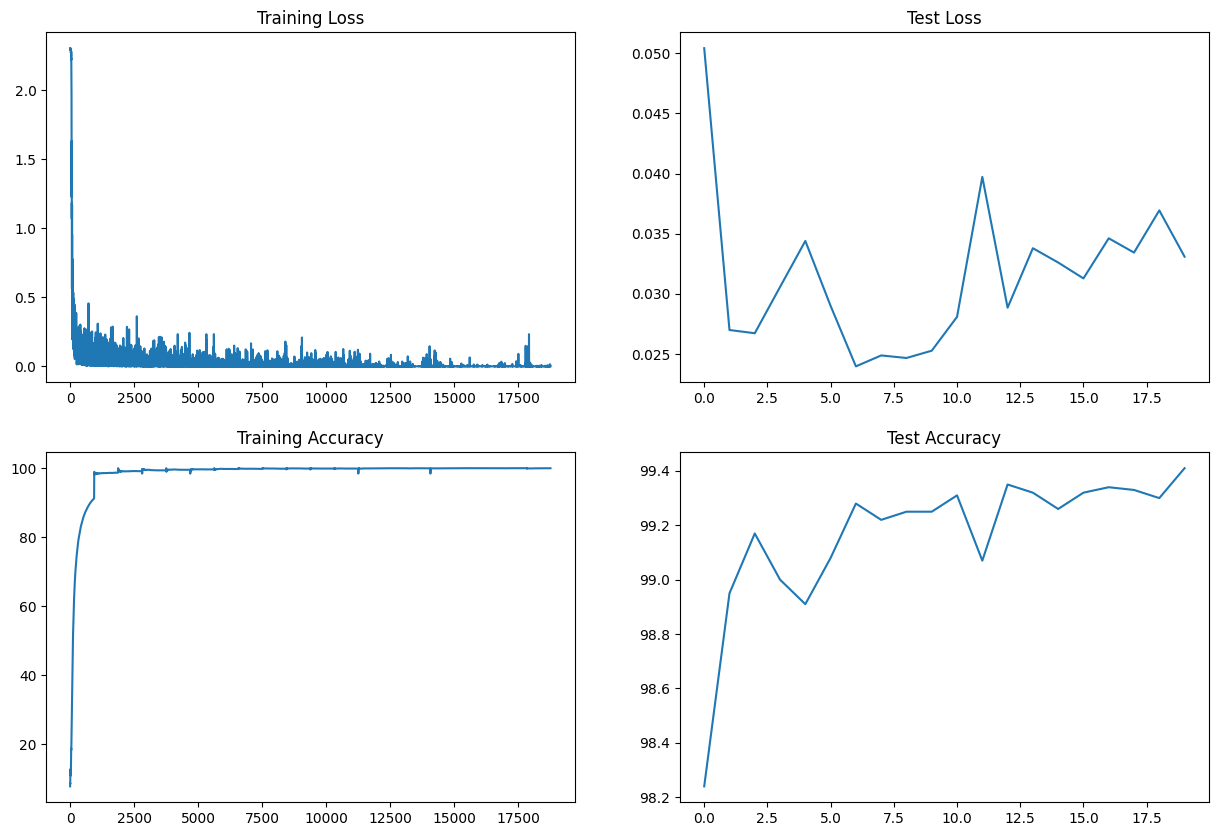

In [12]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

**Target:**
  

*   Get the set-up right
*   Set Transforms
*   Set Data Loader
*   Set Basic Working Code
*   Set Basic Training  & Test Loop


**Results:**


*   Parameters: 6.3M
*   Best Training Accuracy: 99.99
*   Best Test Accuracy: 99.41


**Analysis:**


*   Heavy Model
*   Model is over-fitting